In [3]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import collections

# load crime data
url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/crimestat.csv'
crimes=pd.read_csv(url, index_col='INC NUMBER')

# load a registry of US zip codes with useful city metadata
url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/uszips.csv'
zips=pd.read_csv(url, index_col="zip")

# load average income 
url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/averageincome.csv'
zip_income=pd.read_csv(url, index_col="zipcode")


In [4]:
# tidy up the columns and make them easier to reference
crimes.rename(columns={"OCCURRED ON":"occured_on", \
                       "OCCURRED TO":"occured_to", \
                       "UCR CRIME CATEGORY":"crime_category", \
                       "100 BLOCK ADDR":"address", \
                       "ZIP":"zip_code", \
                       "PREMISE TYPE":"location_type"}, inplace=True)

# not all crimes are created equal, let's identify violent crimes
crime_type=[]
for index, crime in crimes.iterrows():
    if (crime.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") | \
        (crime.crime_category=="RAPE") | \
        (crime.crime_category=="AGGRAVATED ASSAULT"):
        crime_type.append('V')
    else:
        crime_type.append('NV')
crimes['crime_type']=crime_type

# check for a few violent and non-violent to make sure all looks good
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") | \
       (crimes.crime_category=="ROBBERY") | \
       (crimes.crime_category=="AGGRAVATED ASSAULT")]

,occured_on,occured_to,crime_category,address,zip_code,location_type,crime_type
INC NUMBER,,,,,,,
201510000015577,11/01/2015 02:00,11/01/2015 06:00,AGGRAVATED ASSAULT,50XX E THOMAS RD,85018.0,RESTAURANT,V
201500002105677,11/01/2015 02:00,11/01/2015 12:00,AGGRAVATED ASSAULT,41XX N 51ST AVE,85031.0,RESTAURANT,V
201500002101067,11/01/2015 04:12,11/01/2015 04:12,MURDER AND NON-NEGLIGENT MANSLAUGHTER,XX N 67TH AVE,85043.0,FENCED COMMERCIAL YARD,V
201500002101137,11/01/2015 04:14,NaN,ROBBERY,138XX S 44TH ST,85044.0,STREET / ROADWAY / ALLEY / SIDEWALK,NV
201500002101372,11/01/2015 06:10,11/01/2015 06:22,AGGRAVATED ASSAULT,42XX N 12TH ST,85014.0,PARKING LOT,V
...,...,...,...,...,...,...,...
201700002024054,11/16/2017 23:50,11/16/2017 23:57,AGGRAVATED ASSAULT,11XX E BUCKEYE RD,85034.0,STREET / ROADWAY / ALLEY / SIDEWALK,V
201700002023906,11/16/2017 23:50,11/16/2017 23:50,ROBBERY,20XX E THUNDERBIRD RD,85022.0,RESTAURANT,NV
201700002030287,11/17/2017 00:00,11/17/2017 00:00,AGGRAVATED ASSAULT,N 19TH AVE & W VOGEL AVE,85021.0,STREET / ROADWAY / ALLEY / SIDEWALK,V


<AxesSubplot:>

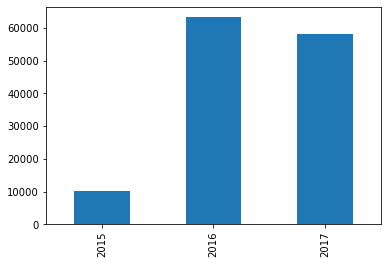

In [5]:
# let's identify case counts by year
def get_year(x):
    if pd.isna(x)!=True:
        return x.year
    else:
        return 'Unknown'

# turn the datetime strings into datetime objects
crimes.occured_on=pd.to_datetime(crimes.occured_on)
crimes.occured_to=pd.to_datetime(crimes.occured_to)

# add a new column for the year
crimes["occured_year"]=crimes.occured_on.apply(lambda x:get_year(x))

# exclude the few that had no occured_on date
yearly_crimes = crimes[(crimes.occured_year!='Unknown')]

# show the sequential annual amounts
yearly_crimes['occured_year'].value_counts().sort_index().plot.bar()

<AxesSubplot:xlabel='occured_year'>

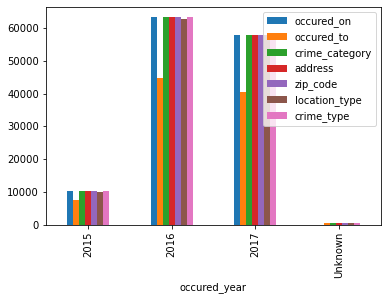

In [6]:
# this is a visual quality check that quickly shows:
#   occured_to is often missing values
#   location_type is ommitted occasionally
#   some had no occured_on date (the 'Unknown')
qual_check = crimes.groupby(by='occured_year').count()
qual_check.plot.bar()

In [7]:
# let's see where the high crme zip codes are by crime volume alone

# prepare our registry of zip codes
zip_crimes_list = crimes.zip_code.unique()
zip_crimes_list_t = []
for zip_entry in zip_crimes_list:
    if pd.isna(zip_entry)==False:
        zip_crimes_list_t.append(str(int(zip_entry)))

# set up a dictionary to associate zips and crime volume
zip_crimes = dict.fromkeys(zip_crimes_list_t,0)

# establish crime volume
for index, crime in crimes.iterrows():
    if pd.isna(crime['zip_code'])==False:
        key = str(int(crime['zip_code']))
        zip_crimes[key]+=1

# order the zip codes by greatest crime volume to least
ordered_zip_crime_volume = sorted(zip_crimes.items(), key=lambda x:x[1], reverse=True)

# gather the top zip codes by incdent count
zip_dict = {}
for i in range(35):
    # gather attribute data
    zip_int      = int(ordered_zip_crime_volume[i][0])
    city         = zips.loc[zip_int,'city'] + \
                   ', '+zips.loc[zip_int,'state_id']
    crime_volume = ordered_zip_crime_volume[i][1]
    population   = zips.loc[zip_int,'population']
    income       = "${:,.2f}".format(zip_income.loc[zip_int,'avg_income'])
    per_capita   = round(crime_volume/population,3)
    
    # load data into our prepared dictionary
    zip_dict[ordered_zip_crime_volume[i][0]]= pd.Series([crime_volume, city, population, per_capita, income], \
                       index =['Crime Volume', 'City', 'Population', 'Crime per Capita', 'Average Income'])

# use the dictionary to create a dataframe
df = pd.DataFrame(zip_dict)
df = df.transpose()
df

,Crime Volume,City,Population,Crime per Capita,Average Income
85015,6963,"Phoenix, AZ",41895.0,0.166,"$38,640.88"
85008,6320,"Phoenix, AZ",62340.0,0.101,"$38,386.56"
85009,5513,"Phoenix, AZ",51711.0,0.107,"$30,201.80"
85041,5477,"Phoenix, AZ",62152.0,0.088,"$41,982.20"
85051,5389,"Phoenix, AZ",45313.0,0.119,"$37,564.47"
85017,5355,"Phoenix, AZ",42656.0,0.126,"$29,001.15"
85035,4752,"Phoenix, AZ",59660.0,0.08,"$31,103.29"
85043,4330,"Phoenix, AZ",38704.0,0.112,"$40,919.21"
85032,4301,"Phoenix, AZ",73203.0,0.059,"$56,899.87"
85033,4258,"Phoenix, AZ",64832.0,0.066,"$31,485.93"


In [8]:
# per capita is more appropriate so let's examine that
df.sort_values(by='Crime per Capita', ascending=False)

,Crime Volume,City,Population,Crime per Capita,Average Income
85034,2649,"Phoenix, AZ",5045.0,0.525,"$43,100.45"
85004,1650,"Phoenix, AZ",7164.0,0.23,"$83,022.25"
85003,1513,"Phoenix, AZ",8499.0,0.178,"$87,024.10"
85015,6963,"Phoenix, AZ",41895.0,0.166,"$38,640.88"
85007,2000,"Phoenix, AZ",14428.0,0.139,"$54,350.55"
85013,2823,"Phoenix, AZ",21028.0,0.134,"$76,062.34"
85017,5355,"Phoenix, AZ",42656.0,0.126,"$29,001.15"
85051,5389,"Phoenix, AZ",45313.0,0.119,"$37,564.47"
85023,3927,"Phoenix, AZ",34268.0,0.115,"$64,926.32"
85043,4330,"Phoenix, AZ",38704.0,0.112,"$40,919.21"


<AxesSubplot:title={'center':'Crime Distribution'}>

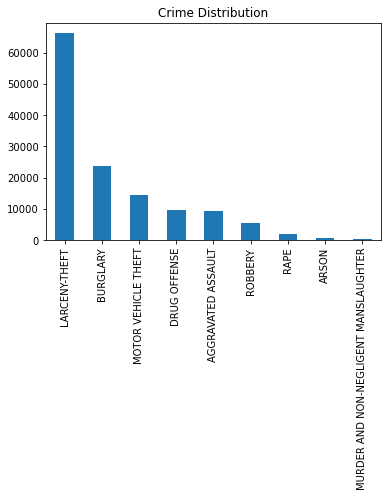

In [9]:
# case counts by crime category - nice to see that low murder bar
crimes.crime_category.value_counts().plot.bar(title='Crime Distribution')

<AxesSubplot:title={'center':'The Crimes of Busy 85034'}>

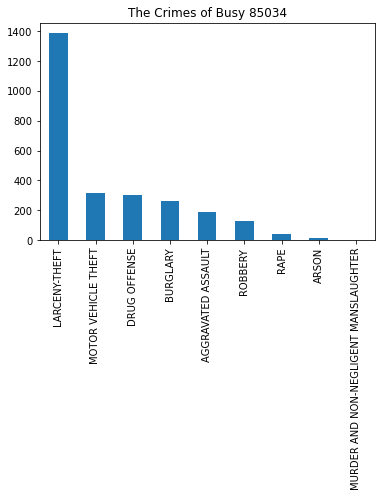

In [10]:
# we know that 85034 has the highest per capita crime rate - what kind of crimes?
crimes[(crimes.zip_code==85034)].crime_category.value_counts().plot.bar(title='The Crimes of Busy 85034')

# 85034 really enjoys theft and one must wonder if the higher count of drug offenses is an underlying cause
# either way - nice job keeping the murder down 85034!

<AxesSubplot:title={'center':'Deadliest Zip Code?'}>

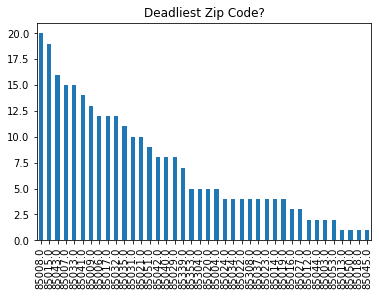

In [11]:
# if 85034 isn't doing much murdering then who is the nefarious leader in this category?
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") \
      ].zip_code.value_counts().plot.bar(title='Deadliest Zip Code?')

<AxesSubplot:title={'center':'Murder Trend for 85008'}>

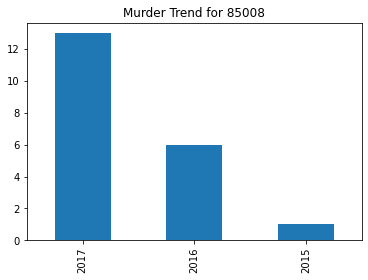

In [12]:
# is this murder habit growing or shrinking for 85008?
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") & (crimes.zip_code==85008) \
      ].occured_year.value_counts().plot.bar(title='Murder Trend for 85008')

# YIKES!

In [13]:
# maybe we are being too hard on 85008.  After all, which zip has the most violent crime per capita?
violent = crimes[(crimes.crime_type=="V") \
      ].zip_code.value_counts()

violent_pc = {}
for z, count in violent.iteritems():
    if z in zips.index:
        violent_pc[z]=(round(count / zips.loc[z,'population'], 6))

#violent_pc.sort(reverse=True)
dict(sorted(violent_pc.items(), key=lambda item: item[1]))

# check the first item where the highest rate is
first_key = int(list(violent_pc.keys())[0])
print("The dubious leader is indeed " + str(first_key) + " at a per capita VIOLENT crime rate of "+ str(violent_pc[first_key]))

The dubious leader is indeed 85008 at a per capita VIOLENT crime rate of 0.010266


In [14]:
# what is the average income for notorious 85008?
"${:,.2f}".format(round(zip_income.loc[85008,'avg_income']))

# below the poverty line ...

'$38,387.00'

<AxesSubplot:title={'center':'Distribution for Wealthiest Zip (What would a Tax Evasion bar look like?)\n'}>

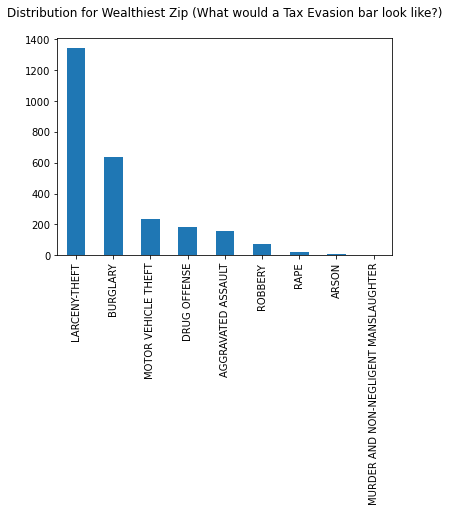

In [15]:
#what kind of crime do we see at our highest average income zip shown further above in the larger crimes table (85018)?
crimes[(crimes.zip_code==85018)].crime_category.value_counts().plot.bar( \
            title="Distribution for Wealthiest Zip (What would a Tax Evasion bar look like?)\n")

In [130]:
#let's save off our crimes data and descriptive top crime zips data frame
crimes.to_csv('essentials_modified_crimes_data.csv')
df.to_csv('essentials_top_crime_zips.csv')